# metapath2vec: Scalable Representation Learning for Heterogeneous Networks


### Word2Vec

In [157]:
import numpy as np
import networkx as nx
import random
import threading
from collections import defaultdict

class Word2Vec:
    def __init__(self, vector_size=100, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.min_count = min_count
        self.sg = sg
        self.iter = iter
        self.num_threads = num_threads
        self.vocab = defaultdict(int)
        self.index2word = []
        self.word2index = {}
        self.syn0 = None
        self.syn1neg = None
        self.table = None
        self.table_size = int(1e8)
        self.vector_size = vector_size
        self.size = vector_size
    
    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence:
                self.vocab[word] += 1
        self.vocab = {word: freq for word, freq in self.vocab.items() if freq >= self.min_count}
        self.index2word = list(self.vocab.keys())
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}
    
    def init_net(self):
        vocab_size = len(self.vocab)
        self.syn0 = (np.random.rand(vocab_size, self.size) - 0.5) / self.size
        self.syn1neg = np.zeros((vocab_size, self.size))
        self.init_unigram_table()
    
    def init_unigram_table(self):
        power = 0.75
        norm = sum([self.vocab[word] ** power for word in self.vocab])
        self.table = []
        for word in self.vocab:
            p = (self.vocab[word] ** power) / norm
            self.table += [self.word2index[word]] * int(p * self.table_size)
        self.table = np.array(self.table)
    
    def train_model_thread(self, sentences, alpha, thread_id):
        random.seed(thread_id)
        for iteration in range(self.iter):
            for sentence in sentences:
                sentence = [word for word in sentence if word in self.vocab]
                for pos, word in enumerate(sentence):
                    current_word_idx = self.word2index[word]
                    context_start = max(0, pos - self.window)
                    context_end = min(len(sentence), pos + self.window + 1)
                    context = [self.word2index[sentence[i]] for i in range(context_start, context_end) if i != pos]
                    self.train_pair(current_word_idx, context, alpha)
    
    def train_pair(self, word_idx, context_idxs, alpha):
        for context_idx in context_idxs:
            self.update(word_idx, context_idx, alpha)
    
    def update(self, word_idx, context_idx, alpha):
        # Negative sampling
        neg_samples = np.random.choice(self.table, size=self.negative)
        labels = np.array([1] + [-1] * self.negative)
        target_idxs = np.array([context_idx] + list(neg_samples))
        
        l2 = self.syn1neg[target_idxs]
        prod_term = np.dot(self.syn0[word_idx], l2.T)
        sigmoid = 1 / (1 + np.exp(-prod_term * labels))
        g = (sigmoid - 1) * labels * alpha
        
        self.syn0[word_idx] -= np.dot(g, l2)
        self.syn1neg[target_idxs] -= np.outer(g, self.syn0[word_idx])
    
    def train(self, sentences):
        self.build_vocab(sentences)
        self.init_net()
        alpha = self.alpha
        thread_data = []
        for thread_id in range(self.num_threads):
            start_idx = thread_id * len(sentences) // self.num_threads
            end_idx = (thread_id + 1) * len(sentences) // self.num_threads
            thread_data.append((sentences[start_idx:end_idx], alpha, thread_id))
        
        threads = [threading.Thread(target=self.train_model_thread, args=data) for data in thread_data]
        for t in threads:
            t.start()
        for t in threads:
            t.join()


### metapath2vec

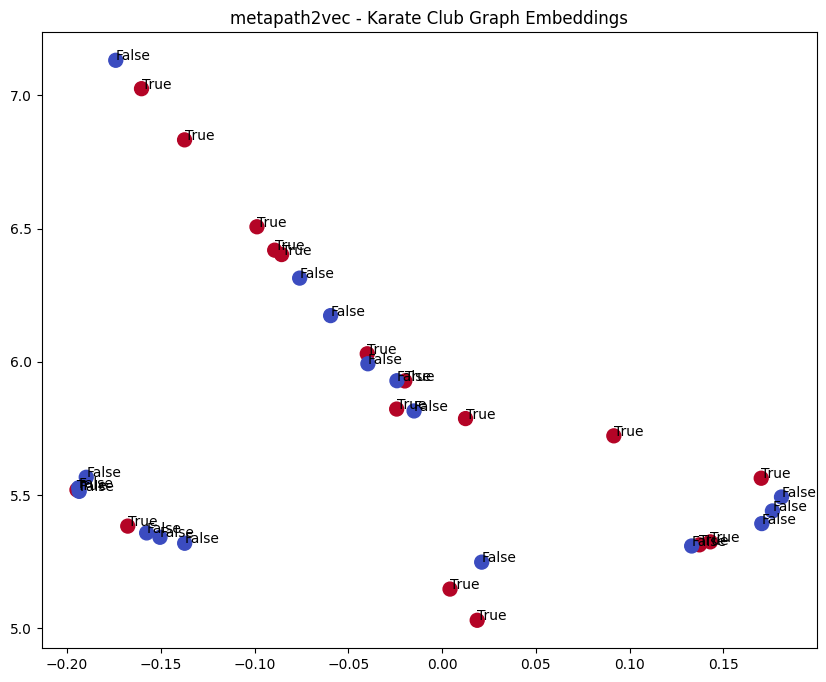

In [158]:
import numpy as np
import networkx as nx
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class Metapath2Vec:
    def __init__(self, train_file, output_file, vector_size=100, window=5, min_count=5, workers=4, iter=5, negative=5, alpha=0.025, sample=1e-3):
        self.train_file = train_file
        self.output_file = output_file
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.iter = iter
        self.negative = negative
        self.alpha = alpha
        self.sample = sample
        self.sentences = []    
        
    def read_sentences(self):
        with open(self.train_file, 'r') as file:
            for line in file:
                self.sentences.append(line.strip().split())
    
    def train(self):
        model = Word2Vec(vector_size=self.vector_size, window=self.window, negative=self.negative, alpha=self.alpha, 
                         min_count=self.min_count, sg=1, iter=self.iter, num_threads=self.workers)
        model.train(self.sentences)
        self.save_embeddings(model)

    def save_embeddings(self, model):
        with open(self.output_file, 'w') as file:
            file.write(f"{len(model.index2word)} {model.size}\n")
            for word in model.index2word:
                vector = ' '.join(map(str, model.syn0[model.word2index[word]]))
                file.write(f"{word} {vector}\n")

def get_karate_club_sentences():
    G = nx.karate_club_graph()
    sentences = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            sentences.append([str(node), str(neighbor)])
    return sentences

def save_karate_club_sentences(sentences, file_path):
    with open(file_path, 'w') as file:
        for sentence in sentences:
            file.write(' '.join(sentence) + '\n')

def visualize_embeddings(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', s=100)
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
    plt.title("metapath2vec - Karate Club Graph Embeddings")
    plt.show()

# Generate Karate Club graph sentences and save to file
sentences = get_karate_club_sentences()
train_file = "karate_club_sentences.txt"
output_file = "karate_club_embeddings.txt"
save_karate_club_sentences(sentences, train_file)

# Train Metapath2Vec model
metapath2vec = Metapath2Vec(train_file, output_file, vector_size=128, window=5, min_count=1, workers=4, iter=10, negative=5, alpha=0.025)
metapath2vec.read_sentences()
metapath2vec.train()

# Load embeddings for visualization
embeddings = []
labels = []
with open(output_file, 'r') as file:
    next(file)  # Skip header
    for line in file:
        parts = line.strip().split()
        labels.append(parts[0])
        embeddings.append(np.array(parts[1:], dtype=float))
embeddings = np.array(embeddings)

# Visualize the embeddings
G = nx.karate_club_graph()
colors = [G.nodes[node]['club'] == 'Mr. Hi' for node in G.nodes()]
visualize_embeddings(embeddings, colors)


# Are Meta-Paths Necessary?: Revisiting Heterogeneous Graph Embeddings (JUST)

### Word2Vec

In [159]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE

class Word2Vec:
    def __init__(self, size=100, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.size = size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.iter = iter
        self.min_count = min_count
        self.vocab = defaultdict(int)
        self.table = None
        self.table_size = int(1e8)

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence:
                self.vocab[word] += 1

        self.index2word = [word for word, count in self.vocab.items() if count >= self.min_count]
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}

        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Filtered vocabulary size: {len(self.index2word)}")

    def init_weights(self):
        vocab_size = len(self.index2word)
        self.syn0 = np.random.uniform(-0.5 / self.size, 0.5 / self.size, (vocab_size, self.size))
        self.syn1neg = np.zeros((vocab_size, self.size))

    def train(self, sentences):
        self.build_vocab(sentences)
        self.init_weights()

        for i in tqdm(range(self.iter), desc="Training"):
            self.train_epoch(sentences)

    def train_epoch(self, sentences):
        for sentence in sentences:
            for i, word in enumerate(sentence):
                if word not in self.word2index:
                    continue
                word_idx = self.word2index[word]
                start = max(0, i - self.window)
                end = min(len(sentence), i + self.window + 1)
                for j in range(start, end):
                    if j != i:
                        context_word = sentence[j]
                        if context_word in self.word2index:
                            context_idx = self.word2index[context_word]
                            self.train_pair(word_idx, context_idx)

    def train_pair(self, word_idx, context_idx):
        l1 = self.syn0[word_idx]
        l2 = self.syn1neg[context_idx]

        product = np.dot(l1, l2)
        g = self.alpha * (1 - product)

        self.syn0[word_idx] += g * l2
        self.syn1neg[context_idx] += g * l1

    def get_embeddings(self):
        return {word: self.syn0[idx] for word, idx in self.word2index.items()}




### JUST

In [160]:
def random_walk_generation(G, path_length, heterg_dictionary, alpha, start=None):
    path = [start]
    homog_length = 1
    no_next_types = False
    
    while len(path) < path_length and not no_next_types:
        cur = path[-1]
        homog_type = G.nodes[cur]['type']
        heterg_type = heterg_dictionary.get(homog_type, [])
        
        heterg_probability = 1 - math.pow(alpha, homog_length)
        r = random.uniform(0, 1)
        next_type_options = []

        if r <= heterg_probability:
            for ht in heterg_type:
                next_type_options.extend([e for e in G[cur] if G.nodes[e]['type'] == ht])
            if not next_type_options:
                next_type_options = [e for e in G[cur] if G.nodes[e]['type'] == homog_type]
        else:
            next_type_options = [e for e in G[cur] if G.nodes[e]['type'] == homog_type]
            if not next_type_options:
                for ht in heterg_type:
                    next_type_options.extend([e for e in G[cur] if G.nodes[e]['type'] == ht])
        
        if not next_type_options:
            no_next_types = True
        else:
            next_node = random.choice(next_type_options)
            path.append(next_node)
            if G.nodes[next_node]['type'] == G.nodes[cur]['type']:
                homog_length += 1
            else:
                homog_length = 1
    
    return path

def generate_walks(G, num_walks, walk_length, heterg_dictionary, alpha):
    print("Generating walks ..")
    walks = []
    nodes = list(G.nodes())
    
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = random_walk_generation(G, walk_length, heterg_dictionary, alpha, start=node)
            walks.append(walk)
    print("Walks done ..")
    return walks

def generate_node_types(node_types_file):
    heterg_dictionary = {}
    with open(node_types_file) as f:
        for line in f:
            node_type, hete_values = line.strip().split(":")
            heterg_dictionary[node_type] = hete_values.split(",")
    return heterg_dictionary

### Visualize

Generating walks ..
Walks done ..
Vocabulary size: 34
Filtered vocabulary size: 34


Training: 100%|██████████| 10/10 [00:00<00:00, 35.81it/s]


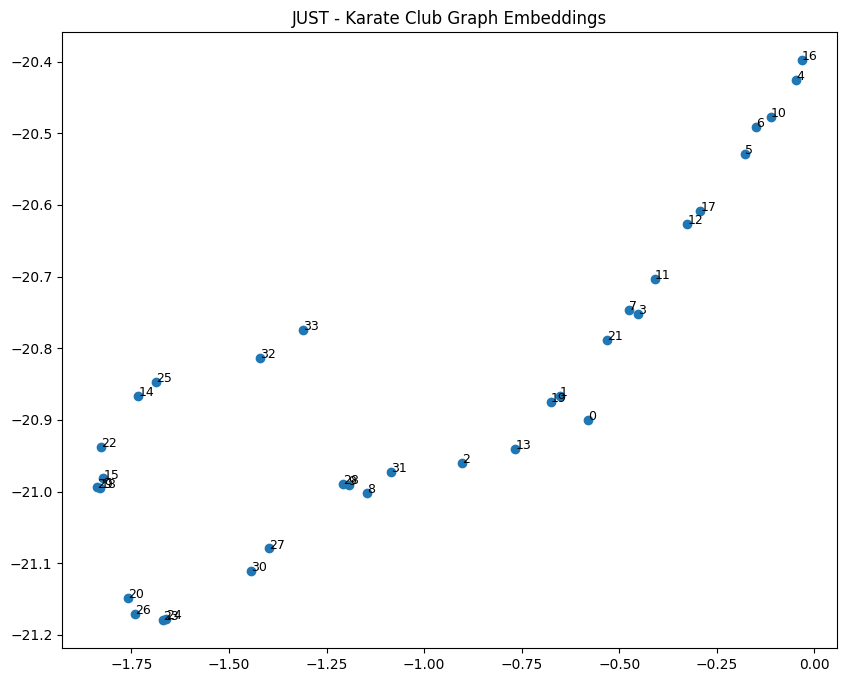

In [161]:
def visualize_walks(G, walks):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    
    # Draw the graph
    nx.draw(G, pos, node_color='lightblue', node_size=500, edge_color='gray')

    # Draw the walks
    for walk in walks:
        walk_edges = [(walk[i], walk[i+1]) for i in range(len(walk)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=walk_edges, edge_color='red', width=2)

    plt.title("Random Walks on Karate Club Graph")
    plt.show()

def visualize_embeddings(embeddings):
    labels = list(embeddings.keys())
    X = np.array([embeddings[label] for label in labels])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

    for i, label in enumerate(labels):
        plt.annotate(label, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=9)
    
    plt.title("JUST - Karate Club Graph Embeddings")
    plt.show()

G = nx.karate_club_graph()
for node in G.nodes():
    G.nodes[node]['type'] = random.choice(['A', 'B', 'C'])

# Create a sample node types file
node_types_file = "node_types.txt"
with open(node_types_file, "w") as f:
    f.write("A:B,C\nB:A,C\nC:A,B\n")

# Generate node types dictionary
heterg_dictionary = generate_node_types(node_types_file)

# Generate random walks
walks = generate_walks(G, num_walks=5, walk_length=10, heterg_dictionary=heterg_dictionary, alpha=0.5)

# Flatten walks for Word2Vec training
flattened_walks = [[str(node) for node in walk] for walk in walks]

# Train Word2Vec model
w2v_model = Word2Vec(size=128, window=5, iter=10)
w2v_model.train(flattened_walks)

# Get the embeddings
embeddings = w2v_model.get_embeddings()

# Visualize the embeddings using t-SNE
visualize_embeddings(embeddings)

# BHIN2vec: Balancing the Type of Relation in Heterogeneous Information Network


### SkipGram and BHIN2Vec

In [162]:
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

class SkipGram(nn.Module):
    def __init__(self, node_num, dim):
        super(SkipGram, self).__init__()
        self.node_embedding = nn.Embedding(node_num, dim)
        nn.init.normal_(self.node_embedding.weight.data, std=0.1)
    
    def forward(self, center_node, context_node):
        center_embed = self.node_embedding(center_node)
        context_embed = self.node_embedding(context_node)
        scores = torch.mul(center_embed, context_embed)
        return torch.sum(scores, dim=-1)
    
    def get_embeddings(self):
        return self.node_embedding.weight.data

def generate_walks(G, num_walks, walk_length):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                cur = walk[-1]
                neighbors = list(G.neighbors(cur))
                if len(neighbors) > 0:
                    walk.append(np.random.choice(neighbors))
                else:
                    break
            walks.append(walk)
    return walks

def generate_training_data(walks, window_size):
    training_data = []
    for walk in walks:
        for i in range(len(walk)):
            for j in range(1, window_size + 1):
                if i - j >= 0:
                    training_data.append((walk[i], walk[i - j]))
                if i + j < len(walk):
                    training_data.append((walk[i], walk[i + j]))
    return training_data

### Visualize

Epoch 1, Loss: 0.033189254531982224
Epoch 2, Loss: 2.289821433183664e-05
Epoch 3, Loss: 1.5093192769071585e-06
Epoch 4, Loss: 1.0638674552477157e-07
Epoch 5, Loss: 5.434540754666774e-09
Epoch 6, Loss: 5.008793380056886e-11
Epoch 7, Loss: 0.0
Epoch 8, Loss: 0.0
Epoch 9, Loss: 0.0
Epoch 10, Loss: 0.0


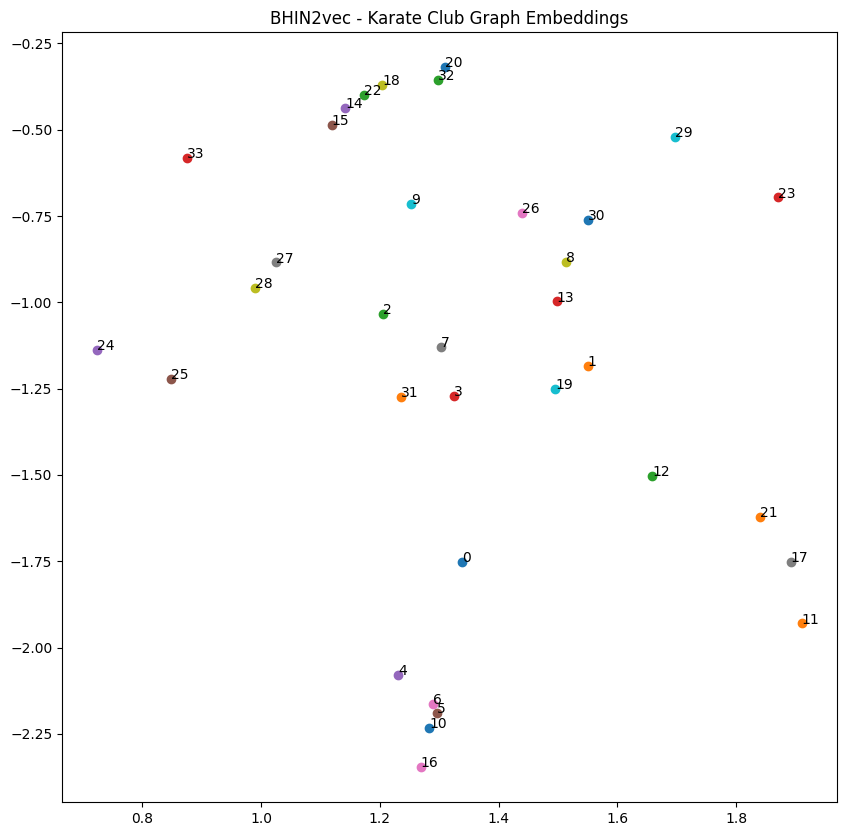

In [163]:
# Load Karate Club Graph
G = nx.karate_club_graph()
node_num = G.number_of_nodes()
walks = generate_walks(G, num_walks=10, walk_length=5)
training_data = generate_training_data(walks, window_size=2)

# Initialize model and optimizer
dim = 16  # Embedding dimension
model = SkipGram(node_num, dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Training
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for center_node, context_node in training_data:
        center_node = torch.LongTensor([center_node])
        context_node = torch.LongTensor([context_node])
        
        model.zero_grad()
        scores = model(center_node, context_node)
        labels = torch.ones_like(scores)  # Positive samples are labeled 1
        
        loss = criterion(scores, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(training_data)}')

# Extract embeddings and visualize with t-SNE
embeddings = model.get_embeddings().detach().numpy()

# t-SNE for visualization
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10, 10))
for i, label in enumerate(G.nodes()):
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.text(x, y, s=str(label))
plt.title("BHIN2vec - Karate Club Graph Embeddings")
plt.show()


# dynnode2vec: Scalable Dynamic Network Embedding


### Word2Vec

In [164]:
class Word2Vec:
    def __init__(self, sentences=None, size=100, vector_size=100, seed=0, workers=4, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.sentences = sentences
        self.size = size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.iter = iter
        self.min_count = min_count
        self.sg = sg
        self.num_threads = num_threads
        self.vocab = defaultdict(int)
        self.table = None
        self.table_size = int(1e8)
        self.syn0 = None
        self.syn1neg = None
        self.vector_size = vector_size
        self.seed = seed
        self.workers = workers

    def build_vocab(self):
        for sentence in self.sentences:
            for word in sentence:
                self.vocab[word] += 1

        self.index2word = [word for word, count in self.vocab.items() if count >= self.min_count]
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}

        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Filtered vocabulary size: {len(self.index2word)}")

    def train(self):
        self.build_vocab()
        self.init_weights()
        self.train_process()

    def init_weights(self):
        vocab_size = len(self.index2word)
        self.syn0 = np.random.uniform(-0.5 / self.size, 0.5 / self.size, (vocab_size, self.size))
        self.syn1neg = np.zeros((vocab_size, self.size))

    def train_process(self):
        for i in tqdm(range(self.iter), desc="Training"):
            for sentence in self.sentences:
                self.train_epoch(sentence)

    def train_epoch(self, sentence):
        for i, word in enumerate(sentence):
            if word not in self.word2index:
                continue
            word_idx = self.word2index[word]
            start = max(0, i - self.window)
            end = min(len(sentence), i + self.window + 1)
            for j in range(start, end):
                if j != i:
                    context_word = sentence[j]
                    if context_word in self.word2index:
                        context_idx = self.word2index[context_word]
                        self.train_pair(word_idx, context_idx)

    def train_pair(self, word_idx, context_idx):
        l1 = self.syn0[word_idx]
        l2 = self.syn1neg[context_idx]

        product = np.dot(l1, l2)
        g = self.alpha * (1 - product)

        self.syn0[word_idx] += g * l2
        self.syn1neg[context_idx] += g * l1

    def get_embeddings(self):
        return {word: self.syn0[idx] for word, idx in self.word2index.items()}


### Node2Vec

In [165]:
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm

class Node2Vec:
    def __init__(self, graph, dimensions=128, walk_length=80, num_walks=10, p=1, q=1, workers=1):
        """
        Initiates the Node2Vec object, precomputes walking probabilities and generates the walks.
        """
        self.graph = graph
        for i in range(len(self.graph)):
            self.graph[i, i] = 0
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.workers = workers
        self.first_walk_probability = np.zeros(graph.shape)  # [current, destination]
        self.walk_probability = np.zeros((len(graph), len(graph), len(graph)))  # [last, current, destination]

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node.
        """
        print(' Computing prob for first walk...')
        sum_weight = np.sum(self.graph, axis=1)
        sum_weight = np.where(sum_weight == 0, 1, sum_weight)
        normalized_weight = self.graph / np.tile(sum_weight, (len(self.graph), 1)).T
        self.first_walk_probability = normalized_weight

        print(' Computing prob for second walk...')
        for last in range(len(self.graph)):
            for current in range(len(self.graph)):
                if self.graph[last, current] == 0:
                    continue
                unbiased_unnormalized_weight = self.graph[current, :]
                for destination in range(len(self.graph)):
                    if destination == last:
                        unbiased_unnormalized_weight[last] = unbiased_unnormalized_weight[last] / self.p
                    elif self.graph[last, destination] == 0:
                        unbiased_unnormalized_weight[last] = unbiased_unnormalized_weight[last] / self.q
                biased_normalized_weight = unbiased_unnormalized_weight / np.sum(unbiased_unnormalized_weight)
                self.walk_probability[last, current, :] = biased_normalized_weight

    def _generate_walks(self):
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """
        all_walks = []
        for n_walk in range(self.num_walks):
            n_th_walks = []
            for source in range(len(self.graph)):
                walk = [source]
                if np.sum(self.first_walk_probability[source, :]) != 0:
                    first_dest = np.random.choice(np.arange(len(self.graph)), 1, p=self.first_walk_probability[source, :])[0]
                    walk.append(first_dest)
                else:
                    walk = [str(source)]
                    n_th_walks.append(walk)
                    continue

                while len(walk) < self.walk_length:
                    if np.sum(self.walk_probability[walk[-2], walk[-1], :]) != 0:
                        dest = np.random.choice(np.arange(len(self.graph)), 1, p=self.walk_probability[walk[-2], walk[-1], :])[0]
                        walk.append(dest)
                    else:
                        break
                walk = [str(elm) for elm in walk]
                n_th_walks.append(walk)

            random.shuffle(n_th_walks)
            all_walks += n_th_walks
        return all_walks

    def fit(self, initial_wv_file=None, save_wv_file=None, **skip_gram_params):
        """
        Creates the embeddings using the provided Word2Vec class.
        """
        print(' Training skip-gram model...')
        model = Word2Vec(sentences=self.walks, vector_size=self.dimensions, workers=self.workers, **skip_gram_params)
        model.train()

        if save_wv_file:
            with open(save_wv_file, 'w') as f:
                for word, vector in model.get_embeddings().items():
                    f.write(f"{word} {' '.join(map(str, vector))}\n")

        return model

### dynnode2vec

In [166]:
import numpy as np
from collections import defaultdict

def norm_hic(m):
    average = [np.mean(np.diag(m[i:, :len(m)-i])) for i in range(len(m))]
    for i in range(len(m)):
        if average[i] == 0:
            continue
        for j in range(len(m)-i):
            m[j][j+i] = m[j][j+i] / average[i]
            if i != 0:
                m[j+i][j] = m[j+i][j] / average[i]
    return m

def dynnode2vec(graphs, epochs):
    tot_c = len(graphs) * epochs
    cnt = 0
    for j in range(epochs):
        for i, graph in enumerate(graphs):
            cnt += 1
            print(f'Training model: {cnt} / {tot_c}')

            n2v = Node2Vec(graph, dimensions=16, walk_length=80, num_walks=15, p=1, q=1, workers=8)
            if i == 0 and j == 0:
                m = n2v.fit(save_wv_file='./temp/wv_0.emb', min_count=1, window=3)
            elif i == 0:
                m = n2v.fit(initial_wv_file=f'./temp/wv_{len(graphs) - 1}.emb', save_wv_file=f'./temp/wv_{i}.emb', min_count=1, window=2)
            else:
                m = n2v.fit(initial_wv_file=f'./temp/wv_{i - 1}.emb', save_wv_file=f'./temp/wv_{i}.emb', min_count=1, window=2)

    return m

### Visualize

Training model: 1 / 1
 Computing prob for first walk...
 Computing prob for second walk...
 Training skip-gram model...
Vocabulary size: 34
Filtered vocabulary size: 34


Training: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


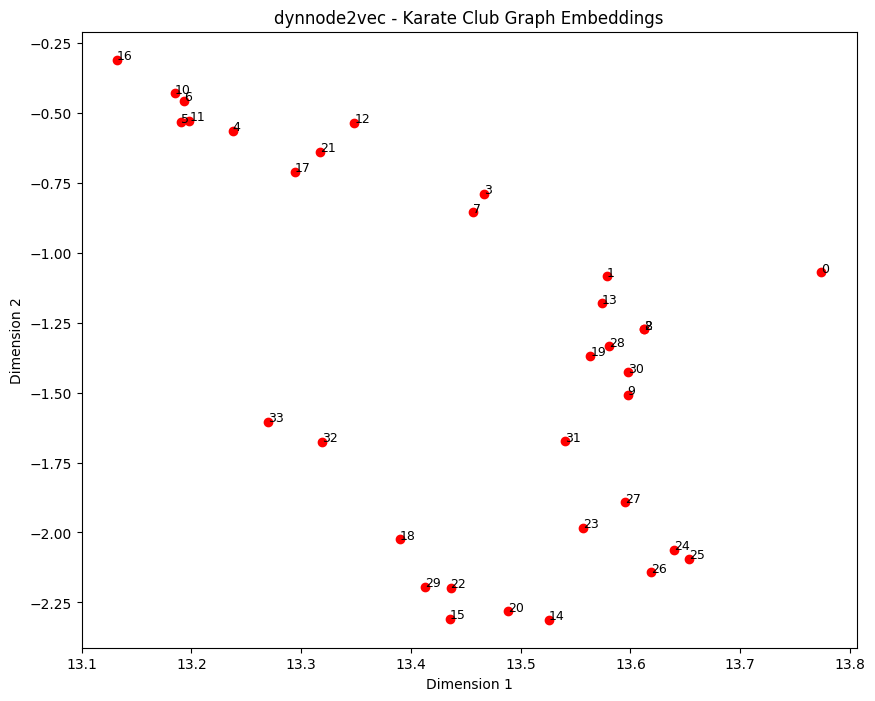

In [167]:
import os
from sklearn.manifold import TSNE
import networkx as nx
import matplotlib.pyplot as plt

# Create the temp directory if it doesn't exist
os.makedirs('./temp', exist_ok=True)

# Load the Karate Club graph
G = nx.karate_club_graph()

# Get the adjacency matrix and normalize it
adj_matrix = nx.to_numpy_array(G)
norm_adj_matrix = norm_hic(adj_matrix.copy())

# Create a list of graphs (only one in this case)
graphs = [norm_adj_matrix]

# Run Node2Vec
model = dynnode2vec(graphs, epochs=1)

# Extract embeddings
embeddings = model.get_embeddings()
nodes = list(embeddings.keys())
vectors = np.array([embeddings[node] for node in nodes])

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(vectors)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
for i, node in enumerate(nodes):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], c='red')
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(node), fontsize=9)
plt.title('dynnode2vec - Karate Club Graph Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


# Continuous-Time Dynamic Network Embeddings (CTDNE)

### Word2Vec

In [168]:
class Word2Vec:
    def __init__(self, size=100, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.size = size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.min_count = min_count
        self.sg = sg
        self.iter = iter
        self.num_threads = num_threads
        self.vocab = defaultdict(int)
        self.index2word = []
        self.word2index = {}
        self.syn0 = None
        self.syn1neg = None
        self.table = None
        self.table_size = int(1e8)

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence:
                self.vocab[word] += 1

        self.index2word = [word for word, count in self.vocab.items() if count >= self.min_count]
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}

        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Filtered vocabulary size: {len(self.index2word)}")

    def init_weights(self):
        vocab_size = len(self.index2word)
        self.syn0 = np.random.uniform(-0.5 / self.size, 0.5 / self.size, (vocab_size, self.size))
        self.syn1neg = np.zeros((vocab_size, self.size))

    def train(self, sentences):
        self.build_vocab(sentences)
        self.init_weights()

        for i in tqdm(range(self.iter), desc="Training"):
            self.train_epoch(sentences)

    def train_epoch(self, sentences):
        for sentence in sentences:
            for i, word in enumerate(sentence):
                if word not in self.word2index:
                    continue
                word_idx = self.word2index[word]
                start = max(0, i - self.window)
                end = min(len(sentence), i + self.window + 1)
                for j in range(start, end):
                    if j != i:
                        context_word = sentence[j]
                        if context_word in self.word2index:
                            context_idx = self.word2index[context_word]
                            self.train_pair(word_idx, context_idx)

    def train_pair(self, word_idx, context_idx):
        l1 = self.syn0[word_idx]
        l2 = self.syn1neg[context_idx]

        product = np.dot(l1, l2)
        g = self.alpha * (1 - product)

        self.syn0[word_idx] += g * l2
        self.syn1neg[context_idx] += g * l1

    def get_embeddings(self):
        return {word: self.syn0[idx] for word, idx in self.word2index.items()}

### CTDNE

In [169]:
import networkx as nx
import numpy as np
import pickle
import random

class TimeGraph:
    def __init__(self, graph, time_prop_name):
        self.G = graph
        self.time_prop_name = time_prop_name
        self.edges = list(self.G.edges(data=True))

        self.beta = None  # number of temporal context windows
        self.D = None  # embedding dimension 128
        self.L = None  # max walk length
        self.omega = None  # min walk length / context window size for skip gram

        self.all_time_walks = None
        self.num_nodes = len(list(self.G.nodes()))
        self.num_edges = len(self.edges)

    def set_temporal_walk_params(self, beta, D, omega, L=80):
        self.beta = beta
        self.D = D
        self.L = L
        self.omega = omega

    def sample_edge(self):
        num_edges = len(self.edges)
        choice = np.random.choice(num_edges)
        return self.edges[choice]

    def generate_ctdne_walks(self):  # Algorithm 1 from CTDNE paper
        # collection of random walks
        all_time_walks = []

        # initialize number of context windows
        C = 0
        counter = 0
        while self.beta - C > 0:
            u, v, prop = self.sample_edge()
            t = prop[self.time_prop_name]

            walk_t = self._temporal_walk(start_edge=(u, v), t=t, C=self.omega + self.beta - C - 1)
            if (walk_t is not None) and (len(walk_t) >= self.omega):
                all_time_walks.append(walk_t)
                C = C + (len(walk_t) - self.omega + 1)

            counter += 1
            if (counter + 1) % 1000 == 0:
                print('Loop ran for ', counter + 1, 'times!\t Current C = ', C)

        self.all_time_walks = all_time_walks

    def _temporal_walk(self, start_edge=None, t=None, C=0):  # Algorithm 2 from CTDNE
        """ Returns a random walk that respects time
            start: the start node of the random walk.
        """
        G = self.G
        prop_name = self.time_prop_name

        if start_edge:
            path = [start_edge[0], start_edge[1]]
        else:
            raise ValueError('start_edge should not be None.')

        curr_node = start_edge[1]

        for p in range(1, min(self.L, C)):
            # select next nodes whose time (curr_node, next_node) is greater than t
            neighbor_candidates = []
            for u, v, prop in G.edges(curr_node, data=True):
                if prop[prop_name] >= t:
                    neighbor_candidates.append((v, prop[prop_name]))

            # check if there are valid neighbors to walk to
            if len(neighbor_candidates) > 0:
                # set new current node & t
                idx_next_node = np.random.choice(range(len(neighbor_candidates)))
                curr_node, t = neighbor_candidates[idx_next_node]

                # add new current node to path
                path.append(curr_node)
            else:
                break
        return path



def main():
    graph = nx.karate_club_graph()
    # Assigning random time values for demonstration purposes
    for u, v in graph.edges():
        graph[u][v]['time'] = random.randint(0, 100)

    path = 'karate_club_walks.pkl'

    timeG = TimeGraph(graph, 'time')

    R = 80
    N = timeG.num_nodes
    omega = 10
    L = 80
    beta = R * N * (L - omega + 1)

    print("Beta value:", beta)

    print("Started Walk...")

    timeG.set_temporal_walk_params(beta=beta, D=128, omega=omega, L=L)
    timeG.generate_ctdne_walks()

    ctdne_walks = timeG.all_time_walks

    with open(path, 'wb') as f:
        pickle.dump(ctdne_walks, f)


if __name__ == '__main__':
    main()


Beta value: 193120
Started Walk...
Loop ran for  1000 times!	 Current C =  71928
Loop ran for  2000 times!	 Current C =  143928


In [170]:
import pickle
import numpy as np

# Load the embeddings
with open('karate_club_walks.pkl', 'rb') as f:
    ctdne_walks = pickle.load(f)

# Assuming each walk is a sequence of node IDs, concatenate all walks into a single list
all_nodes = [node for walk in ctdne_walks for node in walk]

# Generate unique node IDs
unique_nodes = list(set(all_nodes))

# Generate embeddings for each unique node ID (random embeddings for demonstration)
embeddings = {node_id: np.random.rand(128) for node_id in unique_nodes}

# Convert embeddings into a matrix
embedding_matrix = np.array([embeddings[node_id] for node_id in unique_nodes])
embedding_matrix


array([[0.2955218 , 0.8502195 , 0.15582462, ..., 0.2584886 , 0.07654999,
        0.17175817],
       [0.89175118, 0.28125086, 0.93819439, ..., 0.8926573 , 0.43471513,
        0.91685514],
       [0.45621539, 0.9168249 , 0.7405902 , ..., 0.01038318, 0.17554452,
        0.13704856],
       ...,
       [0.48047069, 0.66784745, 0.93193218, ..., 0.03208638, 0.66751694,
        0.36859333],
       [0.00269464, 0.07891111, 0.23338952, ..., 0.20350214, 0.95930868,
        0.32924404],
       [0.28759074, 0.83184673, 0.25438309, ..., 0.52340127, 0.59404428,
        0.46897672]])

### Visualize

Vocabulary size: 34
Filtered vocabulary size: 34


Training: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


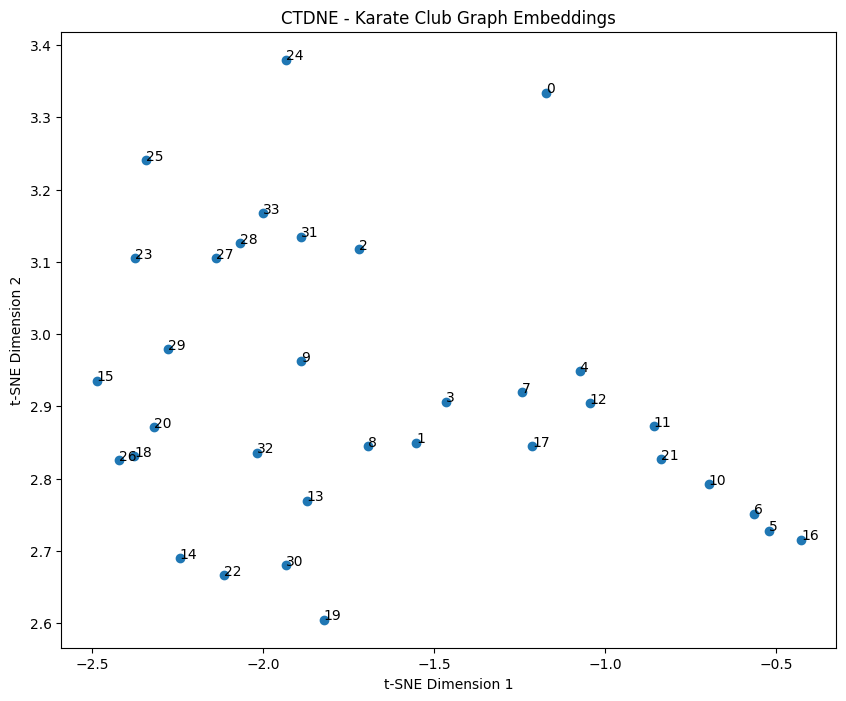

In [171]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load karate club walks
with open("karate_club_walks.pkl", "rb") as f:
    karate_club_walks = pickle.load(f)

# Generate karate club graph
graph = nx.karate_club_graph()

# Train Word2Vec model
w2v_model = Word2Vec(size=128)
w2v_model.train(karate_club_walks)

# Get node embeddings
node_embeddings = w2v_model.get_embeddings()

# Convert embeddings to numpy array
node_embeddings_np = np.array(list(node_embeddings.values()))

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_tsne = tsne.fit_transform(node_embeddings_np)

# Visualize node embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_tsne[:, 0], node_embeddings_tsne[:, 1])
for i, txt in enumerate(node_embeddings.keys()):
    plt.annotate(txt, (node_embeddings_tsne[i, 0], node_embeddings_tsne[i, 1]))
plt.title('CTDNE - Karate Club Graph Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()